In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usa-airport-dataset/Airports2.csv


# Step 1: Data Preprocessing

In this step, we will:
1. Load the dataset from the Kaggle input folder.
2. Inspect the structure of the dataset to understand its attributes.
3. Clean and preprocess the data:
   - Ensure no missing or irrelevant columns.
   - Convert necessary data types.
   - Filter out irrelevant or duplicate records.
4. Prepare the data for building the graph in later steps.


In [9]:
# Import required libraries
import pandas as pd

# Load the dataset from the Kaggle directory
file_path = '/kaggle/input/usa-airport-dataset/Airports2.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset successfully loaded!")
print(df.head())

Dataset successfully loaded!
  Origin_airport Destination_airport    Origin_city Destination_city  \
0            MHK                 AMW  Manhattan, KS         Ames, IA   
1            EUG                 RDM     Eugene, OR         Bend, OR   
2            EUG                 RDM     Eugene, OR         Bend, OR   
3            EUG                 RDM     Eugene, OR         Bend, OR   
4            MFR                 RDM    Medford, OR         Bend, OR   

   Passengers  Seats  Flights  Distance    Fly_date  Origin_population  \
0          21     30        1       254  2008-10-01             122049   
1          41    396       22       103  1990-11-01             284093   
2          88    342       19       103  1990-12-01             284093   
3          11     72        4       103  1990-10-01             284093   
4           0     18        1       156  1990-02-01             147300   

   Destination_population  Org_airport_lat  Org_airport_long  \
0                   86219    

In [10]:
# Load the full dataset (replace with your file path)
file_path = '/kaggle/input/usa-airport-dataset/Airports2.csv'
df = pd.read_csv(file_path)

# Extract a random sample of 1000 rows
df_sample = df.sample(n=1000, random_state=42)

# Save the sample as a smaller CSV
df_sample.to_csv('sample_dataset.csv', index=False)

### Inspecting Dataset Columns

We need to understand the structure of the dataset:
1. Identify all columns and their data types.
2. Check for missing or irrelevant columns.
3. Ensure key attributes such as origin and destination airports are present and valid.


In [13]:
# Check the structure of the dataset
print("Dataset Info:")
print(df.info())

# Display column names
print("Columns in the dataset:")
print(df.columns)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB
None
Columns in the dataset:
Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_dat

### Data Cleaning

After inspecting the dataset:
1. Ensure no missing values in critical columns (`Origin_airport`, `Destination_airport`).
2. Remove duplicate rows, if any.
3. Handle any unexpected or invalid data points (e.g., empty strings or null values in key columns).


In [14]:
# Drop rows with missing values in key columns
df_cleaned = df.dropna(subset=['Origin_airport', 'Destination_airport'])

# Remove duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Confirm cleaning results
print("After cleaning:")
print(f"Number of rows: {len(df_cleaned)}")
print(f"Columns: {df_cleaned.columns}")

After cleaning:
Number of rows: 3565050
Columns: Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')


### Preparing the Data for Graph Construction

Now that the dataset is clean:
1. We will extract the key columns for graph construction:
   - `Origin_airport`: This will represent the source nodes in the graph.
   - `Destination_airport`: This will represent the target nodes in the graph.
2. We will save the cleaned data for use in graph creation.


In [15]:
# Extract necessary columns for graph construction
graph_data = df_cleaned[['Origin_airport', 'Destination_airport']].copy()

# Display a preview of the prepared data
print("Prepared Data for Graph Construction:")
print(graph_data.head())

Prepared Data for Graph Construction:
  Origin_airport Destination_airport
0            MHK                 AMW
1            EUG                 RDM
2            EUG                 RDM
3            EUG                 RDM
4            MFR                 RDM


 ## Step 2: Minimum Cut for Graph Disconnection

Now that the data is cleaned and ready we will apply the **minimum cut algorithm** to the flight network graph creating a function.  
The goal of the minimum cut is to **disconnect the graph** by removing the smallest possible number of edges (flights). Mathematically, this approach ensures that the graph is split into two distinct subgraphs, $p_1$ and $p_2$, where no edges connect the nodes in $p_1$ with the nodes in $p_2$.

### Function Overview

The function is structured as follows:

1. **Graph Construction**:  
   - An undirected graph is created using the `networkx` library.  
   - Nodes represent airports (`Origin_airport` and `Destination_airport`).  
   - Edges represent flights between airports, and we assign a fixed weight (`capacity=1`) to each edge.

2. **Selection of Source and Sink Nodes**:  
   - A **source node** (first airport in the dataset) and a **sink node** (last airport in the dataset) are chosen.  
   - These nodes serve as the starting and ending points for the minimum cut calculation.

3. **Minimum Cut Calculation**:  
   - The `nx.minimum_cut` function is applied to identify the smallest set of edges (flights) whose removal disconnects the graph.  
   - This ensures that no edges connect nodes in partition $p_1$ (reachable nodes) with nodes in partition $p_2$ (non-reachable nodes).

4. **Removed Edges**:  
   - The function prints the edges (flights) that were removed to achieve the disconnection.

5. **Graph Visualization**:
   - **Original Flight Network**: A visualization of the entire graph before disconnection.  
   - **Disconnected Graph**: A visualization of the graph after removing the identified edges, highlighting the two resulting subgraphs:
     - Nodes in **Partition 1** are colored **red**.
     - Nodes in **Partition 2** are colored **blue**.

---

### Function Input and Output

- **Input**: A cleaned dataset (`graph_data`) containing these two columns:  
  - `Origin_airport`: The origin airport code.  
  - `Destination_airport`: The destination airport code.

- **Output**:
  1. The **value of the minimum cut**: the number of edges (flights) removed.
  2. The **list of edges** removed to disconnect the graph.
  3. Visualizations:
     - The **original graph** with all connections.
     - The **disconnected graph** highlighting the two resulting subgraphs.


In [30]:
import networkx as nx
import matplotlib.pyplot as plt

def airline_network_partitioning(df):
    """
    Function to disconnect a flight network into two subgraphs by removing the minimum number of flights.
    
    Parameters:
        df (DataFrame): DataFrame containing 'Origin_airport' and 'Destination_airport'.
        
    Outputs:
        - Prints the edges (flights) removed.
        - Visualizes the original flight network.
        - Visualizes the two resulting disconnected subgraphs.
    """
    # 1. Graph Creation with Explicit Edge Weights
    G = nx.DiGraph()  # Directed Graph to support minimum_cut
    for _, row in df.iterrows():
        G.add_edge(row['Origin_airport'], row['Destination_airport'], capacity=1)  # Weight of 1 for each edge
        G.add_edge(row['Destination_airport'], row['Origin_airport'], capacity=1)  # Makes the graph undirected

    # 2. Selecting Source and Sink Nodes for Minimum Cut
    source = list(G.nodes)[0]  # First node as source
    sink = list(G.nodes)[-1]   # Last node as sink
    
    # 3. Calculating Minimum Cut
    cut_value, partition = nx.minimum_cut(G, source, sink)
    reachable, non_reachable = partition
    removed_edges = [(u, v) for u in reachable for v in non_reachable if G.has_edge(u, v)]
    
    print(f"Minimum Cut Value (number of edges removed): {cut_value}")
    print("Edges (flights) removed to disconnect the graph:")
    for edge in removed_edges:
        print(edge)
    
    # 4. Visualization of the Original Network
    plt.figure(figsize=(12, 6))
    plt.title("Original Flight Network")
    pos = nx.spring_layout(G, seed=42)  # Layout for the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
    plt.show()
    
    # 5. Creating the Resulting Subgraphs
    G_removed = G.copy()
    G_removed.remove_edges_from(removed_edges)
    
    # 6. Visualization of the Resulting Subgraphs
    plt.figure(figsize=(12, 6))
    plt.title("Flight Network After Minimum Cut")
    
    # Color nodes based on their partition
    node_colors = ['red' if node in reachable else 'blue' for node in G_removed.nodes()]
    nx.draw(G_removed, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=500)
    plt.show()

Minimum Cut Value (number of edges removed): 1
Edges (flights) removed to disconnect the graph:
('YIP', 'PHD')


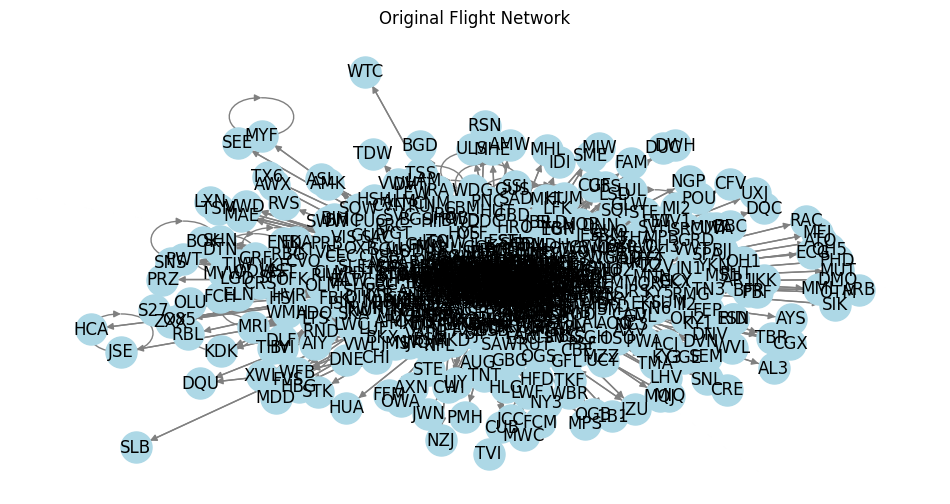

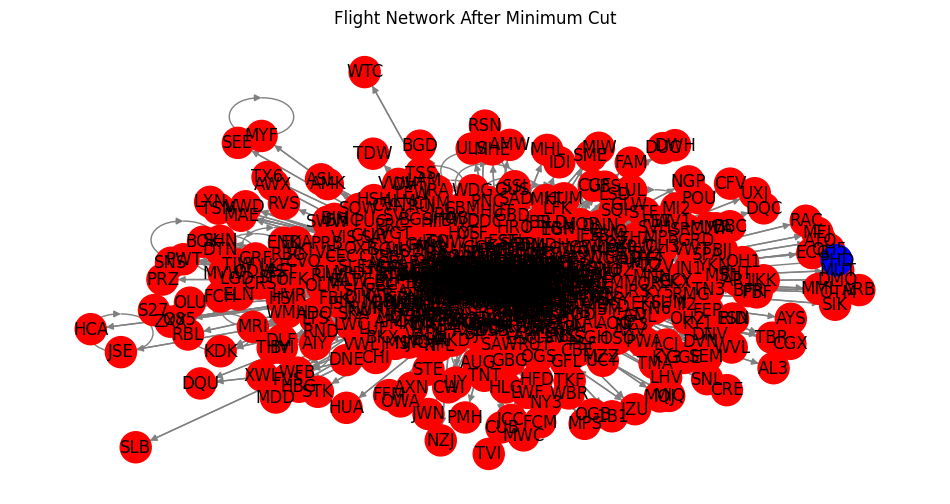

In [25]:
airline_network_partitioning(graph_data)

### Why Minimum Cut May Be Small  
In some networks, like our case, the **minimum cut** can result in just one or very few edges being removed. This typically occurs if:
- The network has **bridge edges**: single connections critical to maintaining connectivity.
- The graph is **highly connected**, but a specific "weak point" exists.

While this result satisfies the **mathematical disconnection condition**, it does not produce a division of the network that is **practically meaningful**.  

---

### The Need for Balanced Partitioning  
From a logical perspective, when dividing the flight network between two airlines, it makes sense to ensure that:
1. Each **partition** (or subgraph) contains a **similar number of flight routes** (edges).  
2. The workload or responsibility of managing these flights is **fairly distributed** between the two airlines.

The minimum cut approach focuses purely on disconnecting the graph with the smallest possible number of edges removed. However, this often leads to an **imbalanced partition** where one group contains most of the flight routes while the other is significantly smaller.

To address this issue, in the next step, we will implement a **balanced partitioning** approach. This method aims to divide the flight network into two **approximately equal-sized partitions**, minimizing the number of edges (routes) between the two groups. This approach better reflects the real-world scenario where the two new airlines would want to share the routes of the original airline as evenly as possible.

By achieving a more balanced division, we ensure that:
- Both airlines receive a **fair share** of the flight network.  
- The division is both **mathematically valid** and **practically meaningful**.


## Step 3: Balanced Partitioning of the Flight Network

In this step, we aim to partition the flight network graph into two **balanced subgraphs**, ensuring that the number of flight routes (edges) in each subgraph is approximately equal. Unlike the minimum cut, which focuses purely on disconnecting the graph by removing as few edges as possible, this approach is **more practical** for the given task.

To achieve this type of partition, we use a particular graph partitioning method called the **Kernighan-Lin algorithm**.

The result will be two balanced partitions that reflect a fair division of the flight network.


### Balanced Partitioning Code

Here's how the `balanced_partitioning` function works:

1. **Graph Creation**:  
   - The graph is constructed using the cleaned dataset. Nodes represent airports, and edges represent routes.

2. **Kernighan-Lin Partitioning**:  
   - The `nx.community.kernighan_lin_bisection` function is used to split the graph into two partitions of approximately equal size, while minimizing the number of edges (routes) between them.

3. **Edges Between Partitions**:  
   - The function identifies and prints the edges (routes) that connect the two partitions. These are the "cut edges" in the balanced partition.

4. **Visualization**:
   - Nodes are colored based on their partition:  
     - **Red** for Partition 1.  
     - **Blue** for Partition 2.  
   - The edges connecting the two partitions are highlighted in **orange** to show the cut.

The result is a **balanced division** of the flight network that better reflects the practical requirement of evenly splitting the routes between two airlines.


In [25]:
import networkx as nx
import matplotlib.pyplot as plt

def balanced_partitioning(graph_data):
    """
    Function to partition the flight network graph into two balanced subgraphs.
    Parameters:
        graph_data (DataFrame): DataFrame containing 'Origin_airport' and 'Destination_airport'.
    Outputs:
        - Prints partition sizes and edges between partitions.
        - Visualizes the graph with the two balanced partitions.
    """
    # 1. Graph Creation
    G = nx.Graph()
    for _, row in graph_data.iterrows():
        G.add_edge(row['Origin_airport'], row['Destination_airport'])

    # 2. Balanced Partitioning using Kernighan-Lin
    partition = nx.community.kernighan_lin_bisection(G)
    group_1, group_2 = partition

    # Edges between partitions
    edges_cut = [(u, v) for u in group_1 for v in group_2 if G.has_edge(u, v)]
    
    print("Balanced Partition Results:")
    print(f"Number of nodes in Partition 1: {len(group_1)}")
    print(f"Number of nodes in Partition 2: {len(group_2)}")
    print(f"Number of edges between partitions: {len(edges_cut)}")

    # 3. Visualization of the partitions
    plt.figure(figsize=(12, 8))
    plt.title("Balanced Flight Network Partitioning")
    pos = nx.spring_layout(G, seed=42)  # Node positioning

    # Color nodes based on their partition
    node_colors = ['red' if node in group_1 else 'blue' for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=50, font_size=5, edge_color='gray')

    # Highlight edges between partitions
    nx.draw_networkx_edges(G, pos, edgelist=edges_cut, edge_color='orange', width=2)
    plt.show()


Balanced Partition Results:
Number of nodes in Partition 1: 363
Number of nodes in Partition 2: 364
Number of edges between partitions: 2249


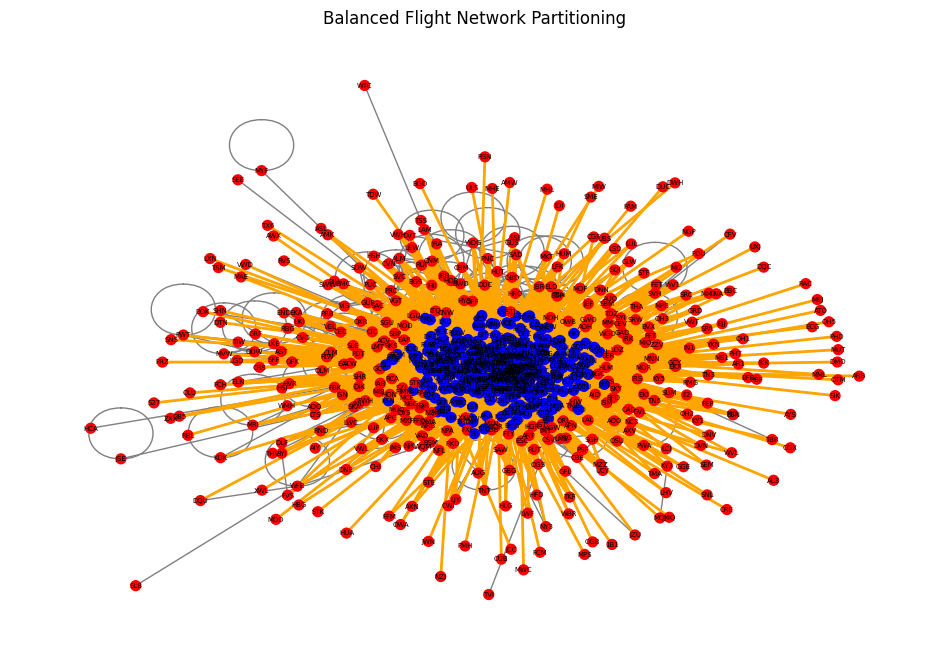

In [19]:
balanced_partitioning(graph_data)

## Balanced Partitioning: Practical Interpretation

The **Balanced Partitioning** graph divides the flight network into two groups with approximately equal nodes (airports) and edges (routes). 

If the two newly created airlines have **similar operational capacities**, this solution would be **practically optimal** for splitting the original airline's network:

1. **Workload Balance**:  
   - Each airline would manage a comparable number of airports and routes, ensuring an equitable distribution of air traffic.  
   - While some **residual connections** still exist between the two groups (representing flights shared between the airlines), these connections are minimal and could be handled as shared services or cooperative codes.

2. **Geographical Interpretation**:  
   - The partition naturally reveals a **central hub** with a dense concentration of airports and connections, likely representing **Central America** or the network's core.  
   - The second group encompasses the **peripheral regions**, where airports are more sparsely connected and spread out.  

### Practical Benefits:
- The **first airline** would focus on **Central America** and key hubs, optimizing operations for high-density routes.  
- The **second airline** would manage the **peripheral regions**, covering regional and lower-density connections effectively.  

### Conclusion:
Despite the **remaining connections** between the two groups, the **Balanced Partitioning** represents a logical and functional solution. It ensures workload balance while providing a clear **geographical division** of responsibilities for the two airlines.
